# Natural Language Processing on the Selected Project Gutenberg Novels 

**Author: Achyut Kafle**

**Introduction:**

In this unsupervised capstone, I use novels and short stories from several authors from the [Project Gutenberg](https://www.gutenberg.org/) and apply several natural language processing techniques on them. More specifically,
* I classify author based on the text of his or her novel using bag of words features;
* I use clustering algorithm to identify the clusters of sentences using bag of words features;
* I use latent semantics analysis (LSA) to generate components from the tf-idf term-document matrix on the selected novel text;
* I use word2vec package to fit unsupervised neural network model on the selected novel text;
* I use advanced topic extraction techniques including Latent Dirichlet Allocation (LDA) and Non-negative Matrix Factorization (NMF) on the selected novel text. 


**Data**

I use a total of 10 novels, 2 novels each from 5 different authors, from the [Project Gutenberg](https://www.gutenberg.org/). 
* "Dubliners" and "Exiles" by James Joyce
* "The Aspern Papers"  and "Daisy Miller: A Stuy" by Henry James
* "The Call of the Wild" and "The Scarlet Plague" by Jack London
* "The Hollow Land" and "The Wood beyond the World" by William Morris
* "England, My England" and "Fantasia of the Unconscious" by D.H. Lawrence

In [1]:
# Import packages

import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import nltk
from nltk.corpus import gutenberg, stopwords
import spacy
import re
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import metrics

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn import ensemble

from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer, normalize

from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import AgglomerativeClustering

import gensim
from gensim.models import word2vec
import networkx as nx
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.decomposition import NMF

# A. Classify author based on the novel text

**1. Import, clean and tokenize novel text**

In [2]:
# James Joyce's novels
dubliners = gutenberg.raw('joyce-dubliners.txt')
exiles=gutenberg.raw('joyce-exiles.txt')

# Henry James' novels
aspern=gutenberg.raw('james-aspern.txt')
daisy=gutenberg.raw('james-daisy.txt')

# Jack London's novels
wild=gutenberg.raw('london-wild.txt')
scarlet=gutenberg.raw('london-scarlet.txt')

# William Morris' novels
hollowland=gutenberg.raw('morris-hollowland.txt')
wood=gutenberg.raw('morris-wood.txt')

# DH Lawrence's novels
england=gutenberg.raw('lawrence-england.txt')
fantasia=gutenberg.raw('lawrence-fantasia.txt')

In [3]:
# Define a function to clean text
def clean_text(text):
    text = re.sub(r'--',' ',text)
    text = re.sub(r'_',' ',text)
    text = re.sub("[\[].*?[\]]", "", text)
    text = ' '.join(text.split())
    return text

In [4]:
# Apply clean_text function to the novels

# James Joyce's novels
dubliners_clean=clean_text(dubliners)
exiles_clean=clean_text(exiles)

# Henry James' novels
aspern_clean=clean_text(aspern)
daisy_clean=clean_text(daisy)

# Jack London's novels
wild_clean=clean_text(wild)
scarlet_clean=clean_text(scarlet)

# William Morris' novels
hollowland_clean=clean_text(hollowland)
wood_clean=clean_text(wood)

# DH Lawrence's novels
england_clean=clean_text(england)
fantasia_clean=clean_text(fantasia)

In [5]:
# Tokenize the novel text

# Spacy nlp
nlp = spacy.load('en')

# James Joyce's novels
dubliners_doc=nlp(dubliners_clean)
exiles_doc=nlp(exiles_clean)

# Henry James' novels
aspern_doc=nlp(aspern_clean)
daisy_doc=nlp(daisy_clean)

# Jack London's novels
wild_doc=nlp(wild_clean)
scarlet_doc=nlp(scarlet_clean)

# William Morris' novels
hollowland_doc=nlp(hollowland_clean)
wood_doc=nlp(wood_clean)

# DH Lawrence's novels
england_doc=nlp(england_clean)
fantasia_doc=nlp(fantasia_clean)

**2. Extract sentences and create dataframe of those sentences with labels as author**

In [6]:
# James Joyce's novels
dubliners_sents=[[sent, "Joyce"] for sent in dubliners_doc.sents]
exiles_sents=[[sent, "Joyce"] for sent in exiles_doc.sents]

# Henry James' novels
aspern_sents=[[sent, "James"] for sent in aspern_doc.sents]
daisy_sents=[[sent, "James"] for sent in daisy_doc.sents]

# Jack London's novels
wild_sents=[[sent, "London"] for sent in wild_doc.sents]
scarlet_sents=[[sent, "London"] for sent in scarlet_doc.sents]

# William Morris' novels
hollowland_sents=[[sent, "Morris"] for sent in hollowland_doc.sents]
wood_sents=[[sent, "Morris"] for sent in wood_doc.sents]

# DH Lawrence's novels
england_sents=[[sent, "Lawrence"] for sent in england_doc.sents]
fantasia_sents=[[sent, "Lawrence"] for sent in fantasia_doc.sents]

In [7]:
# Count sentences
print("Dubliners (Joyce) has {} sentences.".format(len(dubliners_sents)))
print("Exiles (Joyce) has {} sentences.".format(len(exiles_sents)))
print("Aspern (James) has {} sentences.".format(len(aspern_sents)))
print("Daisy (James) has {} sentences.".format(len(daisy_sents)))
print("Call willd (London) has {} sentences.".format(len(wild_sents)))
print("Scarlet (London) has {} sentences.".format(len(scarlet_sents)))
print("Hollow land (Morris) has {} sentences.".format(len(hollowland_sents)))
print("Wood (Morris) has {} sentences.".format(len(wood_sents)))
print("My England (Lawrence) has {} sentences.".format(len(england_sents)))
print("Fantasia (Lawrence) has {} sentences.".format(len(fantasia_sents)))

Dubliners (Joyce) has 4560 sentences.
Exiles (Joyce) has 4727 sentences.
Aspern (James) has 1892 sentences.
Daisy (James) has 1415 sentences.
Call willd (London) has 1692 sentences.
Scarlet (London) has 1340 sentences.
Hollow land (Morris) has 535 sentences.
Wood (Morris) has 1745 sentences.
My England (Lawrence) has 5989 sentences.
Fantasia (Lawrence) has 4108 sentences.


In [8]:
# Combine the sentences from all novels into one data frame.
sentences = pd.DataFrame(dubliners_sents  + exiles_sents + aspern_sents + daisy_sents + wild_sents +
                         scarlet_sents + hollowland_sents + wood_sents +  england_sents + fantasia_sents)
sentences.head()

,0,1
0,"(There, was, no, hope, for, him, this, time, :...",Joyce
1,"(Night, after, night, I, had, passed, the, hou...",Joyce
2,"(If, he, was, dead, ,, I, thought, ,, I, would...",Joyce
3,"(He, had, often, said, to, me, :, âI, am, no...",Joyce
4,"(and, I, had, thought, his, words, idle, .)",Joyce


**3. Create a dataframe with a unique set of the most common words from all novels (word frequency in each sentence)**

In [9]:
# Utility function to create a list of the 150 most common words.
def bag_of_words(text):
    
    # Filter out punctuation and stop words.
    allwords = [token.lemma_
                for token in text
                if not token.is_punct
                and not token.is_stop]
    
    # Return the most common words.
    return [item[0] for item in Counter(allwords).most_common(150)]

In [10]:
def bow_features(sentences, common_words):
    # Scaffold the data frame and initialize counts to zero.
    df = pd.DataFrame(columns=common_words)
    df['text_sentence'] = sentences[0]
    df['text_source'] = sentences[1]
    df.loc[:, common_words] = 0
    
    # Process each row, counting the occurrence of words in each sentence.
    for i, sentence in enumerate(df['text_sentence']):
        
        # Convert the sentence to lemmas, then filter out punctuation, stop words, and uncommon words.
        words = [token.lemma_
                 for token in sentence
                 if (
                     not token.is_punct
                     and not token.is_stop
                     and token.lemma_ in common_words
                 )]
        
        # Populate the row with word counts.
        for word in words:
            df.loc[i, word] += 1
        
        # This counter is just to make sure the kernel didn't hang.
        if i % 500 == 0:
            print("Processing row {}".format(i))
            
    return df

In [11]:
# James Joyce's novels
dublinerswords=bag_of_words(dubliners_doc)
exileswords=bag_of_words(exiles_doc)

# Henry James' novels
aspernwords=bag_of_words(aspern_doc)
daisywords=bag_of_words(daisy_doc)

# Jack London's novels
wildwords=bag_of_words(wild_doc)
scarletwords=bag_of_words(scarlet_doc)

# William Morris' novels
hollowlandwords=bag_of_words(hollowland_doc)
woodwords=bag_of_words(wood_doc)

# DH Lawrence's novels
myenglandwords=bag_of_words(england_doc)
fantasiawords=bag_of_words(fantasia_doc)

# Combine bags to create a set of unique words.
common_words = set(dublinerswords + exileswords +  aspernwords + daisywords + wildwords + scarletwords +
                  hollowlandwords + woodwords + myenglandwords + fantasiawords )

In [12]:
# Create our data frame with features. 
word_counts = bow_features(sentences, common_words)
word_counts.head()

Processing row 0
Processing row 500
Processing row 1000
Processing row 1500
Processing row 2000
Processing row 2500
Processing row 3000
Processing row 3500
Processing row 4000
Processing row 4500
Processing row 5000
Processing row 5500
Processing row 6000
Processing row 6500
Processing row 7000
Processing row 7500
Processing row 8000
Processing row 8500
Processing row 9000
Processing row 9500
Processing row 10000
Processing row 10500
Processing row 11000
Processing row 11500
Processing row 12000
Processing row 12500
Processing row 13000
Processing row 13500
Processing row 14000
Processing row 14500
Processing row 15000
Processing row 15500
Processing row 16000
Processing row 16500
Processing row 17000
Processing row 17500
Processing row 18000
Processing row 18500
Processing row 19000
Processing row 19500
Processing row 20000
Processing row 20500
Processing row 21000
Processing row 21500
Processing row 22000
Processing row 22500
Processing row 23000
Processing row 23500
Processing row 2

,hath,mode,weep,mean,sol,walter,quickly,o,speak,good,...,man,circle,new,chapter,act,think,mrs.,wood,text_sentence,text_source
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(There, was, no, hope, for, him, this, time, :...",Joyce
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(Night, after, night, I, had, passed, the, hou...",Joyce
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,"(If, he, was, dead, ,, I, thought, ,, I, would...",Joyce
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(He, had, often, said, to, me, :, âI, am, no...",Joyce
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,"(and, I, had, thought, his, words, idle, .)",Joyce


**4. Split the final dataframe of outcome (Y) and features (X) into train and test sets**

In [13]:
# Seperate outcome (Y) and bag of words features (X)
Y = word_counts['text_source']
X = np.array(word_counts.drop(['text_sentence','text_source'], 1))
print('Shape of Y: ', Y.shape[0])
print('Shape of X: ', X.shape)

Shape of Y:  28003
Shape of X:  (28003, 649)


In [14]:
# Split samples into train (60%) and test (40%) samples
X_train, X_test, y_train, y_test = train_test_split(X, Y,test_size=0.40, random_state=321)
print('Train samples: ', X_train.shape)
print('Test samples: ', X_test.shape)

Train samples:  (16801, 649)
Test samples:  (11202, 649)


**5. Apply supervised learning models**

_a. K-Nearest Neighbors_

In [16]:
knn=KNeighborsClassifier()
train = knn.fit(X_train, y_train)

print('Training set accuracy score:', knn.score(X_train, y_train))
print('\nTest set accuracy score:', knn.score(X_test, y_test))
print('\nCross-validated accuracy score: \n', cross_val_score(knn, X, Y, cv=7))

Training set accuracy score: 0.6207963811677877

Test set accuracy score: 0.4955365113372612

Cross-validated accuracy score: 
 [0.39095678 0.44802599 0.43678161 0.4445     0.4785     0.50250125
 0.5       ]


_b. Support Vector_

In [17]:
svc=SVC()
train = svc.fit(X_train, y_train)

print('Training set accuracy score:', svc.score(X_train, y_train))
print('\nTest set accuracy score:', svc.score(X_test, y_test))
print('\nCross-validated accuracy score: \n', cross_val_score(svc, X, Y, cv=7))

Training set accuracy score: 0.49931551693351583

Test set accuracy score: 0.4875915015175861

Cross-validated accuracy score: 
 [0.42368224 0.47026487 0.49950025 0.53375    0.53675    0.52001001
 0.518009  ]


_c. Multi-nomial Logistic Regression_

In [18]:
lr = LogisticRegression(solver='lbfgs', multi_class='multinomial')
train = lr.fit(X_train, y_train)

print('Training set accuracy score:', lr.score(X_train, y_train))
print('\nTest set accuracy score:', lr.score(X_test, y_test))
print('\nCross-validated accuracy score: \n', cross_val_score(lr, X, Y, cv=7))

Training set accuracy score: 0.728766144872329

Test set accuracy score: 0.6889841099803606

Cross-validated accuracy score: 
 [0.54634024 0.6161919  0.63443278 0.64025    0.706      0.69284642
 0.7086043 ]


_d. Random Forest_

In [20]:
rfc = ensemble.RandomForestClassifier()
train = rfc.fit(X_train, y_train)

print('Training set accuracy score:', rfc.score(X_train, y_train))
print('\nTest set accuracy score:', rfc.score(X_test, y_test))
print('\nCross-validated accuracy score: \n', cross_val_score(rfc, X, Y, cv=7))

Training set accuracy score: 0.9004225938932207

Test set accuracy score: 0.6251562221031959

Cross-validated accuracy score: 
 [0.48888334 0.54772614 0.5852074  0.608      0.64025    0.64632316
 0.65157579]


_e. Gradient Boosting_

In [22]:
gboost = ensemble.GradientBoostingClassifier()
train = gboost.fit(X_train, y_train)

print('Training set accuracy score:', gboost.score(X_train, y_train))
print('\nTest set accuracy score:', gboost.score(X_test, y_test))
print('\nCross-validated accuracy score: \n', cross_val_score(gboost, X, Y, cv=7) )

Training set accuracy score: 0.6384143800964228

Test set accuracy score: 0.6104267095161579

Cross-validated accuracy score: 
 [0.49737697 0.53498251 0.60194903 0.60925    0.614      0.61055528
 0.62456228]


**Summary of the supervised learning models using bag of words**
* Multi-nomial logistic regression performs the best consistently on both the training (72% accuracy) and test sets (68% accuracy) although random forest has the highest accuracy (90%) for the training set most likely due to overfitting. 
* Gradient boosting model has lower accuracy but shows consistent results for both training and test sets.
* KNN and support vector perform worse among the models considered.
* Model accuracy can be improved by increasing the number of the most common words used in the bag of words features since currently only 150 most common words from each novel are considered. 
* Model accuracy can also be improved by tuning hyperparameters of the models. 

# B. Cluster the novel sentences using bag of words features

_a. K means_

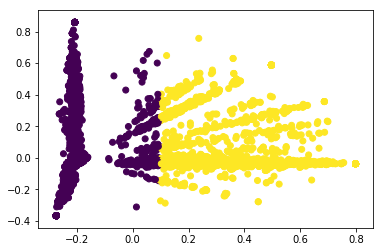

2 clusters: comparing k-means clusters against the data
text_source  James  Joyce  Lawrence  London  Morris
row_0                                              
0             1725   6429      6750    2128    1545
1             1582   2858      3347     904     735


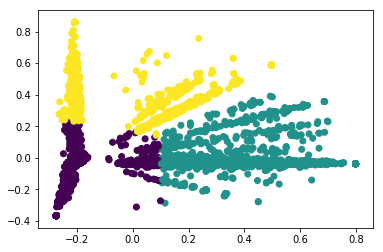

3 clusters: comparing k-means clusters against the data
text_source  James  Joyce  Lawrence  London  Morris
row_0                                              
0             1469   5822      6411    2098    1315
1             1491   2707      3107     889     640
2              347    758       579      45     325


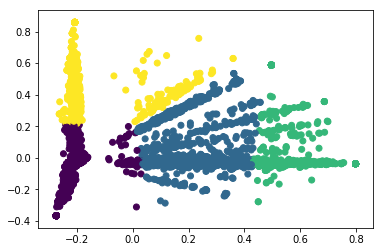

4 clusters: comparing k-means clusters against the data
text_source  James  Joyce  Lawrence  London  Morris
row_0                                              
0             1425   5791      6339    2043    1252
1             1025   1644      2249     669     635
2              564   1208      1173     284     197
3              293    644       336      36     196


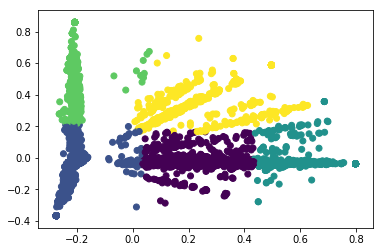

5 clusters: comparing k-means clusters against the data
text_source  James  Joyce  Lawrence  London  Morris
row_0                                              
0              952   1538      2022     663     480
1             1428   5792      6339    2043    1256
2              534   1170      1131     279     173
3              237    593       336      32     194
4              156    194       269      15     177


In [23]:
# Normalize the data.
X_norm = normalize(X)

# Reduce it to two components.
X_pca = PCA(2).fit_transform(X_norm)

# 2 clusters
# Calculate predicted values.
y_pred = KMeans(n_clusters=2, random_state=321).fit_predict(X_pca)

# Plot the solution.
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred)
plt.show()

# Check the solution against the data.
print('2 clusters: comparing k-means clusters against the data')
print(pd.crosstab(y_pred, Y))


# 3 clusters
# Calculate predicted values.
y_pred = KMeans(n_clusters=3, random_state=321).fit_predict(X_pca)

# Plot the solution.
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred)
plt.show()

# Check the solution against the data.
print('3 clusters: comparing k-means clusters against the data')
print(pd.crosstab(y_pred, Y))

# 4 clusters
# Calculate predicted values.
y_pred = KMeans(n_clusters=4, random_state=321).fit_predict(X_pca)

# Plot the solution.
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred)
plt.show()

# Check the solution against the data.
print('4 clusters: comparing k-means clusters against the data')
print(pd.crosstab(y_pred, Y))

# 5 clusters
# Calculate predicted values.
y_pred = KMeans(n_clusters=5, random_state=321).fit_predict(X_pca)

# Plot the solution.
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred)
plt.show()

# Check the solution against the data.
print('5 clusters: comparing k-means clusters against the data')
print(pd.crosstab(y_pred, Y))

_b. Mean-shift_

Number of estimated clusters : 8


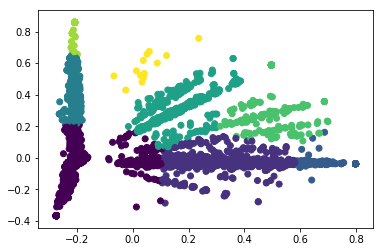

Comparing the assigned categories to the ones in the data:
col_0           0     1    2    3    4   5   6  7
text_source                                      
James        1473  1186  224  225  126  60  10  3
Joyce        5819  2217  452  534  160  45  51  9
Lawrence     6421  2692  369  285  229  50  51  0
London       2104   779   94   28   19   3   4  1
Morris       1318   502   46  189  156  64   5  0


In [24]:
# The following bandwidth can be automatically detected using
bandwidth = estimate_bandwidth(X_pca, quantile=0.2, n_samples=500)

# Declare and fit the model.
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X_pca)

# Extract cluster assignments for each data point.
labels = ms.labels_

# Coordinates of the cluster centers.
cluster_centers = ms.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters : %d" % n_clusters_)

# Plot
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels)
plt.show()

print('Comparing the assigned categories to the ones in the data:')
print(pd.crosstab(Y, labels))

_c. Agglomerative clustering_

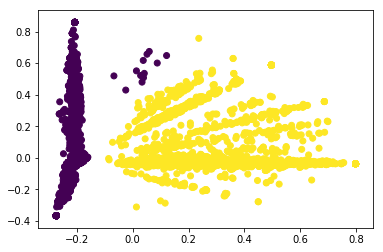

2 clusters: comparing k-means clusters against the data
text_source  James  Joyce  Lawrence  London  Morris
row_0                                              
0             1661   6376      6665    2070    1389
1             1646   2911      3432     962     891


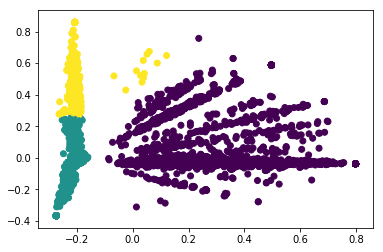

3 clusters: comparing k-means clusters against the data
text_source  James  Joyce  Lawrence  London  Morris
row_0                                              
0             1646   2911      3432     962     891
1             1430   5810      6337    2041    1235
2              231    566       328      29     154


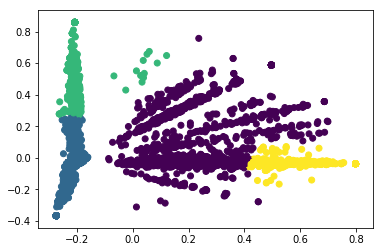

4 clusters: comparing k-means clusters against the data
text_source  James  Joyce  Lawrence  London  Morris
row_0                                              
0             1115   1737      2301     680     731
1             1430   5810      6337    2041    1235
2              231    566       328      29     154
3              531   1174      1131     282     160


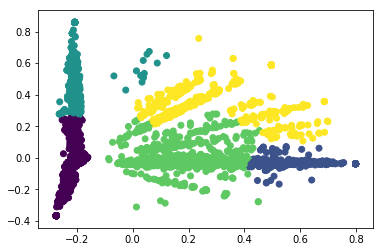

5 clusters: comparing k-means clusters against the data
text_source  James  Joyce  Lawrence  London  Morris
row_0                                              
0             1430   5810      6337    2041    1235
1              531   1174      1131     282     160
2              231    566       328      29     154
3              955   1547      2028     668     566
4              160    190       273      12     165


In [25]:
# 2 cluster
# Calculate predicted values.
y_pred = AgglomerativeClustering(n_clusters=2).fit_predict(X_pca)

# Plot the solution.
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred)
plt.show()

# Check the solution against the data.
print('2 clusters: comparing k-means clusters against the data')
print(pd.crosstab(y_pred, Y))


# 3 clusters
# Calculate predicted values.
y_pred = AgglomerativeClustering(n_clusters=3).fit_predict(X_pca)

# Plot the solution.
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred)
plt.show()

# Check the solution against the data.
print('3 clusters: comparing k-means clusters against the data')
print(pd.crosstab(y_pred, Y))

# 4 clusters
# Calculate predicted values.
y_pred = AgglomerativeClustering(n_clusters=4).fit_predict(X_pca)

# Plot the solution.
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred)
plt.show()

# Check the solution against the data.
print('4 clusters: comparing k-means clusters against the data')
print(pd.crosstab(y_pred, Y))

# 5 clusters
# Calculate predicted values.
y_pred = AgglomerativeClustering(n_clusters=5).fit_predict(X_pca)

# Plot the solution.
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred)
plt.show()

# Check the solution against the data.
print('5 clusters: comparing k-means clusters against the data')
print(pd.crosstab(y_pred, Y))

In [30]:
# Adjusted Rand Index (ARI)
clusters=[2,3,4,5,6,7,8,9,10]
for k in clusters:
    y_pred = AgglomerativeClustering(n_clusters=k).fit_predict(X_pca)
    print('Adjusted Rand Index for ', k, 'clusters is : ', metrics.adjusted_rand_score(Y, y_pred))

Adjusted Rand Index for  2 clusters is :  0.012435286460240344
Adjusted Rand Index for  3 clusters is :  0.013647997913385949
Adjusted Rand Index for  4 clusters is :  0.017807123122428905
Adjusted Rand Index for  5 clusters is :  0.0197020209845174
Adjusted Rand Index for  6 clusters is :  0.013584717950509046
Adjusted Rand Index for  7 clusters is :  0.013080757832578341
Adjusted Rand Index for  8 clusters is :  0.0178925544240618
Adjusted Rand Index for  9 clusters is :  0.017776601035931854
Adjusted Rand Index for  10 clusters is :  0.01780188903346624


**Summary of clustering of novel sentences**

* K-means and agglomerative clustering algorithms group novel sentences more or less similarly for 2-5 clusters graphically represented here. For the purpose of illustration, I only kept two components from the principal component analysis of bag of words features used for the supervised learning models above.
* It is interesting that the adjusted rand index for the 5 clusters from the agglomerative clustering is the highest although all values are less than 0.1 indicating that the clustering solutions are close to random.
* Interestingly, mean shift algorithm estimated 8 clusters for the data potentially indicating that the 10 novels  considered here more or less each form a cluster.

# C. Latent Semantic Analysis

**Some background on LSA**

* Latent semantic analysis (LSA) is the process of applying principal component analysis to a tf-idf term-document matrix, a vector representation of text data. 
* LSA reduces the tf-idf matrix into a lower-dimensional space thus expressing information in the matrix by combining information from multiple terms into a single dimension. 
* The output of the LSA  is clusters of terms that presumably reflect a topic. Each document will get a score for each topic, with higher scores indicating that the document is relevant to the topic. Documents can pertain to more than one topic. 
* LSA is best suited when the corpus is too large, or when topics characterizing documents are unknown. It can also be used to create reduced features as an input to other models. 
* While LSA is good for dealing with synonyms, it cannot handle polysemy (different meanings for the same word depending on the context of use). 

**For the LSA, I am using paragraphs from "England, My England" by D.H. Lawrence since it has the most data of all 10 novels considered.** 

**1. Import paragraphs from "England, My England"**

In [31]:
# DH Lawrence's novels
england_para=gutenberg.paras('lawrence-england.txt')

In [32]:
# Extract paragraphs
england_paras=[]
for paragraph in  england_para:
    para=paragraph[0]
    para=[re.sub(r'--','',word) for word in para]
    england_paras.append(' '.join(para))
    
print(england_paras[0:5])

['He was working on the edge of the common , beyond the small brook that ran in the dip at the bottom of the garden , carrying the garden path in continuation from the plank bridge on to the common .', "There was a sound of children ' s voices calling and talking : high , childish , girlish voices , slightly didactic and tinged with domineering : ' If you don ' t come quick , nurse , I shall run out there to where there are snakes .'", 'His heart was hard with disillusion : a continual gnawing and resistance .', 'The sunlight blazed down upon the earth , there was a vividness of flamy vegetation , of fierce seclusion amid the savage peace of the commons .', 'Ah , how he had loved it !']


**2. Generate tf-idf term-document matrix**

In [33]:
# Define vectorizer
vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the paragraphs
                             min_df=2, # only use words that appear at least twice
                             stop_words='english', 
                             lowercase=True, # convert everything to lower case
                             use_idf=True,# use inverse document frequencies in the weighting
                             norm=u'l2', # use correction factor to treat longer and shorter paragraphs equally
                             smooth_idf=True #Adds 1 to all document frequencies. Prevents divide-by-zero errors
                            )

# Apply the vectorizer
england_tfidf=vectorizer.fit_transform(england_paras)
print("Number of features: %d" % england_tfidf.get_shape()[1])

Number of features: 1160


**3. Split data into train and test sets**

In [34]:
# Split text into training and test sets
X_train, X_test = train_test_split(england_paras, test_size=0.4, random_state=321)
X_train_tfidf, X_test_tfidf= train_test_split(england_tfidf, test_size=0.4, random_state=321)

#Reshape the vectorizer  and count number of paragraphs
X_train_tfidf_csr = X_train_tfidf.tocsr()
n = X_train_tfidf_csr.shape[0]

#A list of dictionaries, one per paragraph
tfidf_bypara = [{} for _ in range(0,n)]

#List of features
terms = vectorizer.get_feature_names()

#For each paragraph, lists the feature words and their tf-idf scores
for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_train_tfidf_csr[i, j]

#Keep in mind that a tf-idf score of 0 indicates that the word was present once in that sentence.
print('Number of paragraphs: %d' %n)
print('Original sentence:', X_train[5])
print('Tf_idf vector:', tfidf_bypara[5])

Number of paragraphs: 1227
Original sentence: No , he had no desire to defy Germany and to exalt England .
Tf_idf vector: {'england': 0.6637457086445084, 'desire': 0.7479583105066746}


**4. Apply LSA to the training data**

In [35]:
# Apply single value decomposition to reduce feature space from 1160 to 200 
svd= TruncatedSVD(200)
lsa = make_pipeline(svd, Normalizer(copy=False))

# Run SVD on the training data, then project the training data.
X_train_lsa = lsa.fit_transform(X_train_tfidf)
variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

# Look at the first five identified topics  
paras_by_component=pd.DataFrame(X_train_lsa,index=X_train)
for i in range(5):
    print('\nComponent {}:'.format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])


Percent variance captured by all components: 63.4244183624317

Component 0:
' It ' s rather behind his back ,' I said .                    0.910762
' No ,' he said .                                              0.910762
' He always has fox terriers ,' he said .                      0.910762
' It might be ,' he said .                                     0.910762
' I should have picked you out among thousands ,' he said .    0.910762
' No ,' she said .                                             0.910762
' Not at all ,' I said .                                       0.910762
' Why , it ' s disgraceful ,' she said .                       0.910762
' Not me ,' he said .                                          0.910762
' I can manage ,' he said .                                    0.910762
Name: 0, dtype: float64

Component 1:
' Yes .                                                        0.929838
' Yes .'                                                       0.929838
' Yes  an ' there ' s 

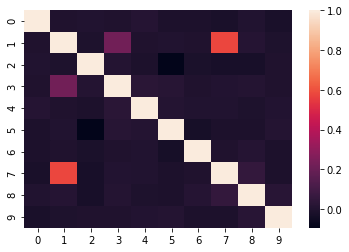

Key:
0 His presence was almost an anguish to Winifred .
1 ' I know he wants to  he ' d only be too glad ,' she replied .
2 Then she forgot the birds in the cart - shed and turned to business again .
3 ' I say , you know ' he began .
4 ' Have you had a letter from Lucy ?'
5 No , he had no desire to defy Germany and to exalt England .
6 ' Yes , of course ,' said Bertie .
7 ' Who wants him ?'
8 ' A man that ' s dying , and you crawling round and working on him for his money ! you ' re not fit to live .'
9 She watched him slowly .


In [36]:
# Compute document similarity using LSA components
similarity = np.asarray(np.asmatrix(X_train_lsa) * np.asmatrix(X_train_lsa).T)

# Take first 10 sentences
sim_matrix=pd.DataFrame(similarity,index=X_train).iloc[0:10,0:10]

#Make a plot
ax = sns.heatmap(sim_matrix,yticklabels=range(10))
plt.show()

#Generate a key for the plot.
print('Key:')
for i in range(10):
    print(i,sim_matrix.index[i])

**Summary of LSA**

* The tf-idf vectorizer identified a total of 1160 words and generated tf-idf scores for those words from the paragraphs of "England, My England".  
* A singular value decoposition (SVD) was used to reduce the dimension of those 1160 features to 200 components capturing 63% of the variance in the data.
* Examining the first few components reveals that paragraphs that contain common words or expression make the component. For example, component one seems to include paragraphs that have direct quotations and the word "said" following the quotations.
* I also calculated the similarity between first 10 sentences and those seem to be quite different as depicted by the heatmap except for a couple of pairs.

# D. Unsupervised neural network using word2vec

**Some background on word2vec**

* It is the most common unsupervised neural network approach for natural language processing for converting words to vectors using distributed representation- each word is represented by many neurons, and each neuron is involved in representing many words. 
* The conceptual difference of word2vec and LSA is that LSA creates vector representations of sentences based on the words in them, while word2vec creates representations of individual words, based on the words around them.
* Word2vec is most useful for situations when computers need to parse requests written by humans when there are so many different ways humans may communicate the same concept. This is because it can even identify similarities between words that never occur near one another in the corpus as it can learn from the context the words are used in.
* A drawback of word2vec is that it works best with a corpus that is at least several billion words long and can take a lot of time to run.

**I am using sentences from two novels ("England, My England" and "Fantasia of the Unconscious") by D.H. Lawrence for the word2vec neural network analysis.**

**1. Combine text data from both novels by D.H. Lawrence**

In [37]:
# Combine two novels by D.H. Lawrence
lawrence = ""
for novel in ['england','fantasia']:
    work = gutenberg.raw('lawrence-' + novel + '.txt')
    lawrence = lawrence + work

# Clean the data.
lawrence_clean = clean_text(lawrence)

# Parse the data. 
lawrence_doc = nlp(lawrence_clean)

In [38]:
# Extract sentences from the clean tokenized/parsed text
sentences = []
for sentence in lawrence_doc.sents:
    sentence = [
        token.lemma_.lower()
        for token in sentence
        if not token.is_stop
        and not token.is_punct
    ]
    sentences.append(sentence)

print(sentences[20])
print('DH Lawrence\'s two novels have {} sentences and {} tokens.'.format(len(sentences), len(lawrence_clean)))

['-pron-', 'flame', 'flower', 'sun', 'cup', 'hedge', 'tree']
DH Lawrence's two novels have 10097 sentences and 700179 tokens.


**2. Apply word2vec model to the data**

In [39]:
model = word2vec.Word2Vec(
    sentences,
    workers=4,     # Number of threads to run in parallel (if your computer does parallel processing).
    min_count=10,  # Minimum word count threshold.
    window=5,      # Number of words around target word to consider.
    sg=0,          # Use CBOW because our corpus is small.
    sample=1e-3 ,  # Penalize frequent words.
    size=300,      # Word vector length.
    hs=1           # Use hierarchical softmax.
)

print('done!')

# List of words in model.
vocab = model.wv.vocab.keys()

done!


In [40]:
# Analogy: plesant:wonderful :: passionate: ?
print(model.wv.most_similar(positive=['pleasant', 'passionate'], negative=['wonderful']))

[('rouse', 0.9990040063858032), ('stoop', 0.9985974431037903), ('move', 0.9984711408615112), ('sound', 0.9983726143836975), ('high', 0.9983004331588745), ('interchange', 0.9982548952102661), ('blow', 0.9982450008392334), ('circle', 0.9982130527496338), ('voice', 0.9980881810188293), ('heavy', 0.9980775117874146)]


/usr/local/lib/python3.7/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [41]:
# Similarity is calculated using the cosine, so 1 is total similarity and 0 is no similarity.
print(model.wv.similarity('wonderful', 'beautiful'))
print(model.wv.similarity('old', 'young'))

0.9903204
0.9712727


/usr/local/lib/python3.7/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [42]:
# Pick the odd one out
print(model.doesnt_match("baby family wife husband bed ".split()))

bed


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `doesnt_match` (Method will be removed in 4.0.0, use self.wv.doesnt_match() instead).
  
/usr/local/lib/python3.7/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


**Summary of unsupervised neural network using word2vec**

* Examining analogy and similarity between words reveal that this model is not great. More data will be required to have improved performance for this type of model.
* Interestingly, the model was able to pick the odd word out, bed, from the group of words- baby, family, wife, husband and bed. 

# E. Extractive text summarization

**Some background on sense2vec**
* word2vec is problematic when two words look the same but have different meanings (homonyms). If both meanings are forced to share a vector, as in word2vec, that vector will end up occupying an uneasy place in the space between vectors. 
* Sense2vec is a modification of word2vec that incorporates information on parts of speech- whether a word is a noun, verb, adjective, etc. In a sense2vec model, break_NOUN has a vector completely separate from break_VERB. In spaCy, text parsing includes tagging each word with its part of speech, which is inferred from the word’s context. 
* To create a sense2vec model, each word in a sentence should be replaced by a string containing the word and its part of speech. After that, we apply the word2vec model-- the push-pull process and vectorization are the same, only the inputs (words vs word_pos strings) change.

_a. Key word extraction_

**1. Generate and apply tf-idf vectorizer**

In [43]:
# Divide text of "England, My England" novel into sentences and store them as a list of strings.
sentences=[]
for span in england_doc.sents:
    sent = ''.join(england_doc[i].string for i in range(span.start, span.end)).strip()
    sentences.append(sent)

# Create the tf-idf matrix.
counter = TfidfVectorizer(lowercase=False, 
                          stop_words=None,
                          ngram_range=(1, 1), 
                          analyzer=u'word', 
                          max_df=.5, 
                          min_df=1,
                          max_features=None, 
                          vocabulary=None, 
                          binary=False)

#Apply the vectorizer
data_counts=counter.fit_transform(sentences)

**2. Calculate the similarity scores for the sentences and apply the TextRank algorithm**

In [44]:
# Calculate similarity
similarity = data_counts * data_counts.T

# Identify the sentence with the highest rank.
nx_graph = nx.from_scipy_sparse_matrix(similarity)
ranks=nx.pagerank(nx_graph, alpha=.85, tol=.00000001)

ranked = sorted(((ranks[i],s) for i,s in enumerate(sentences)),reverse=True)
print('Highest ranked sentence:\n', ranked[0])

Highest ranked sentence:
 (0.0004203247402285251, 'It was as if she had the life of his body in her hands, and he could not extricate himself.')


**3. Calculate neighbors of words and run the TextRank on the neighbor matrix to extract key words**

In [45]:
# Remove stop words and punctuation, then get a list of all unique words in the text
england_filter = [word for word in england_doc if word.is_stop==False and (word.pos_=='NOUN' or word.pos_=='ADJ')]
words=set(england_filter)

#Create a grid indicating whether words are within 4 places of the target word
adjacency=pd.DataFrame(columns=words,index=words,data=0)

#Iterate through each word in the text and indicate which of the unique words are its neighbors
for i,word in enumerate(england_doc):
    # Check if any of the word's next four neighbors are in the word list 
    if any([word == item for item in england_filter]):
        # Make sure to stop at the end of the string, even if there are less than four words left after the target.
        end=max(0,len(england_doc)-(len(england_doc)-(i+5)))
        # The potential neighbors.
        nextwords=england_doc[i+1:end]
        # Filter the neighbors to select only those in the word list
        inset=[x in england_filter for x in nextwords]
        neighbors=[nextwords[i] for i in range(len(nextwords)) if inset[i]]
        # Add 1 to the adjacency matrix for neighbors of the target word
        if neighbors:
            adjacency.loc[word,neighbors]=adjacency.loc[word,neighbors]+1

print('done!')

done!


In [46]:
# Run the TextRank
nx_words = nx.from_numpy_matrix(adjacency.as_matrix())
ranks=nx.pagerank(nx_words, alpha=.85, tol=.00000001)

# Identify the five most highly ranked keywords
ranked = sorted(((ranks[i],s) for i,s in enumerate(words)),reverse=True)
print('Five most highly ranked keywords:\n', ranked[:5])

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Five most highly ranked keywords:
 [(0.00012044292798374209, continuation), (0.00011951036456305758, head), (0.00011951036456305758, cinema), (0.00011951036456305758, feelings), (0.00011951036456305758, works)]


_b. Advanced text extraction_

**1. Generate the tf-idf matrix**

In [47]:
# Create the tf-idf matrix.
vectorizer = TfidfVectorizer(stop_words='english')
england_paras_tfidf=vectorizer.fit_transform(england_paras)

# Get the word list.
terms = vectorizer.get_feature_names()

# Number of topics.
ntopics=5

# Linking words to topics
def word_topic(tfidf,solution, wordlist):
    
    # Load scores for each word on each topic/component.
    words_by_topic=tfidf.T * solution

    # Link the loadings to the words in an easy-to-read way.
    components=pd.DataFrame(words_by_topic,index=wordlist)
    
    return components

# Extract the top N words and their loadings for each topic.
def top_words(components, n_top_words):
    n_topics = range(components.shape[1])
    index= np.repeat(n_topics, n_top_words, axis=0)
    topwords=pd.Series(index=index)
    for column in range(components.shape[1]):
        # Sort the column so that highest loadings are at the top.
        sortedwords=components.iloc[:,column].sort_values(ascending=False)
        # Choose the N highest loadings.
        chosen=sortedwords[:n_top_words]
        # Combine loading and index into a string.
        chosenlist=chosen.index +" "+round(chosen,2).map(str) 
        topwords.loc[column]=chosenlist
    return(topwords)

# Number of words to look at for each topic.
n_top_words = 10

**2a. Fit the Latent Semantic Analysis (LSA)**

In [48]:
#LSA
svd= TruncatedSVD(ntopics)
lsa = make_pipeline(svd, Normalizer(copy=False))

england_paras_lsa = lsa.fit_transform(england_paras_tfidf)
components_lsa = word_topic(england_paras_tfidf, england_paras_lsa, terms)
topwords=pd.DataFrame()
topwords['LSA']=top_words(components_lsa, n_top_words)                

**2b. Fit the Latent Dirichlet Allocation (LDA)**

In [49]:
# LDA
lda = LDA(n_topics=ntopics, 
          doc_topic_prior=None, # Prior = 1/n_documents
          topic_word_prior=1/ntopics,
          learning_decay=0.7, # Convergence rate.
          learning_offset=10.0, # Causes earlier iterations to have less influence on the learning
          max_iter=10, # when to stop even if the model is not converging (to prevent running forever)
          evaluate_every=-1, # Do not evaluate perplexity, as it slows training time.
          mean_change_tol=0.001, # Stop updating the document topic distribution in E-step when mean change is < tol
          max_doc_update_iter=100, # Stop updating the document topic distribution in the E-step if tol is not reached
          n_jobs=-1, # Use all available CPUs to speed up processing time.
          verbose=0, # amount of output to give while iterating
          random_state=321
         )

england_paras_lda = lda.fit_transform(england_paras_tfidf) 
components_lda = word_topic(england_paras_tfidf, england_paras_lda, terms)
topwords['LDA']=top_words(components_lda, n_top_words)

/usr/local/lib/python3.7/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
/usr/local/lib/python3.7/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


**2c. Fit the Non-negative Matrix Factorization (NMF)**

In [50]:
# NMF
nmf = NMF(alpha=0.0, 
          init='nndsvdar', # how starting value are calculated
          l1_ratio=0.0, # Sets whether regularization is L2 (0), L1 (1), or a combination (values between 0 and 1)
          max_iter=200, # when to stop even if the model is not converging (to prevent running forever)
          n_components=ntopics, 
          random_state=321, 
          solver='cd', # Use Coordinate Descent to solve
          tol=0.0001, # model will stop if tfidf-WH <= tol
          verbose=0 # amount of output to give while iterating
         )

england_paras_nmf = nmf.fit_transform(england_paras_tfidf) 
components_nmf = word_topic(england_paras_tfidf, england_paras_nmf, terms)
topwords['NMF']=top_words(components_nmf, n_top_words)

**3. Inspect the topics**

In [51]:
for topic in range(ntopics):
    print('Topic {}:'.format(topic))
    print('Top words: \n', topwords.loc[topic])
    print('\n')

Topic 0:
Top words: 
             LSA           LDA          NMF
0    said 95.82      oh 16.55   said 15.19
0      ll 16.88    said 16.27      ll 1.59
0    come 14.05     came 8.29     yes 1.46
0  bertie 12.95    going 7.56    come 1.44
0     yes 11.54     like 7.51  bertie 1.07
0      ve 10.91  replied 6.79     don 1.06
0     don 10.48      yes 6.13    know 1.04
0     got 10.15      went 6.0      oh 0.98
0  isabel 10.14   father 4.54  isabel 0.96
0  hadrian 9.81      boy 4.16   think 0.83


Topic 1:
Top words: 
              LSA           LDA            NMF
1      yes 25.57    said 20.42       yes 9.27
1       oh 17.24  looked 13.51      said 1.74
1  replied 10.97     joe 12.71   replied 1.07
1       isn 6.16     did 11.58        oh 0.86
1   answered 6.1    come 10.19      does 0.54
1      does 5.23     want 7.34  answered 0.51
1    coming 4.75   bertie 6.98       isn 0.31
1     going 3.67      got 6.94       man 0.31
1     shall 3.32     eyes 6.92    coming 0.27
1     berry 2.95     

**4. Examine sparsity by looking at distribution of loadings of the selected words across the methods**

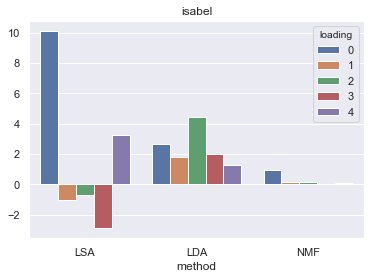

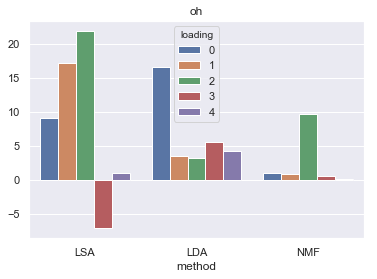

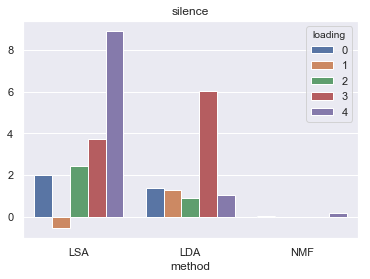

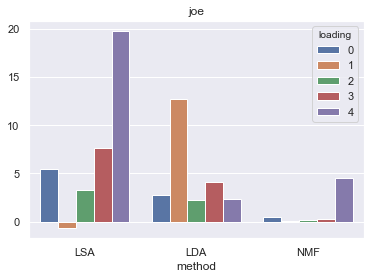

In [52]:
# The words to look at.
targetwords=['isabel','oh','silence','joe']

# Store the loadings.
wordloadings=pd.DataFrame(columns=targetwords)

# For each word, extract and string the loadings for each method.
for word in targetwords:
    loadings=components_lsa.loc[word].append(
        components_lda.loc[word]).append(
            components_nmf.loc[word])
    wordloadings[word]=loadings

# Label the data by method and providing an ordering variable for graphing purposes. 
wordloadings['method']=np.repeat(['LSA','LDA','NMF'], 5, axis=0)
wordloadings['loading']=[0,1,2,3,4]*3

sns.set(style="darkgrid")

for word in targetwords:
    sns.barplot(x="method", y=word, hue="loading", data=wordloadings)
    plt.title(word)
    plt.ylabel("")
    plt.show()

**Summary of key word and advanced topic extraction models including LDA and NMF**

* Although topics generated by different models shared some commons, key words extracted from the text of "England, My England" do not look impressive. Certainly these types of models require a lot more data than used here.  

# Conclusions

**Major conclusions**

I list below the major conclusions from this analysis of the application of natural language processing techinques on the selected Project Gutenberg novels. 

* Among the supervised learning models considered using the bag of words features, multi-nomial logistic regression performed the best consistently on both the training (72% accuracy) and test sets (68% accuracy) although random forest has the highest accuracy (90%) for the training set most likely due to overfitting.

* While k-means and agglomerative clustering algorithms suggested 5 clusters (5 authors' 10 novels are considered in this analysis), mean shift estimated 8 clusters potentially suggesting that the 10 novels  considered here more or less each form a cluster.

* Latent semantic analysis, unsupervised neural network model using word2vec and advanced key word and topic extraction models are not that great for the selected novels considered here but these models suggest some promising results. More data will be required to improve performace of these models as these types of models demand a lot more data than is avialble in this analysis. 